<blockquote style="margin-right:auto; margin-left:auto; color:white; background-color: lightseagreen; padding: 1em; margin:24px;">

<font color="white" size=+3.0><b>Summary</b></font>  
        
<ul>
<li> Tried several classifiers (such as LogisticRegression, ExtraTrees and kNN, VotingClassifiers, etc..) and blended submission at older versions of the NB. However, the current best model is found to be a single Logistic regression model.
<li> Also tried feature engineering by creating new features.
<li> Only used 12 features (6 original and 6 derived). Going forward <strong> this might change with further experiments</strong>.                                                                                                                
    
</ul>        
</blockquote>

#### Import Libararies

In [1]:
# all may not be needed

import os
import sys
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pylab as plt
from colorama import Fore, Back, Style


from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression,HuberRegressor
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import StackingClassifier,VotingClassifier,StackingClassifier

from catboost import CatBoostClassifier

from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PowerTransformer, LabelEncoder, StandardScaler, MinMaxScaler

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


In [2]:
train = pd.read_csv('../input/tabular-playground-series-aug-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-aug-2022/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-aug-2022/sample_submission.csv')

### 1. Dataset Overview

In [3]:
train.head(3)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0


In [4]:
test.head(3)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995


#### Data size
- Train dataset  has 26570 rows and 25 columns including the target column (failure).
- Test dataset has 20775 rows and 24 columsn.

In [5]:
display(train.shape)
display(test.shape)

(26570, 26)

(20775, 25)

#### Null values
- Around 3% of the data (cells) is missing in both train and test datset.
- We will need to impute.

In [6]:
print('Train data missing value is = {} %'.format(100* train.isna().sum().sum()/(len(train)*25)))
print('Test data missing value is  = {} %'.format(100* test.isna().sum().sum()/(len(test)*25)))

Train data missing value is = 3.052013549115544 %
Test data missing value is  = 3.0245968712394706 %


In [7]:
train_na_cols = [col for col in train.columns if train[col].isnull().sum()!=0]
print('Train data cols with missing values ares: \n', train_na_cols)

print('\n')

test_na_cols = [col for col in test.columns if test[col].isnull().sum()!=0]
print('Train data cols with missing values ares: \n', test_na_cols)

Train data cols with missing values ares: 
 ['loading', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']


Train data cols with missing values ares: 
 ['loading', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']


In [8]:
!pip install missingno

<AxesSubplot:>

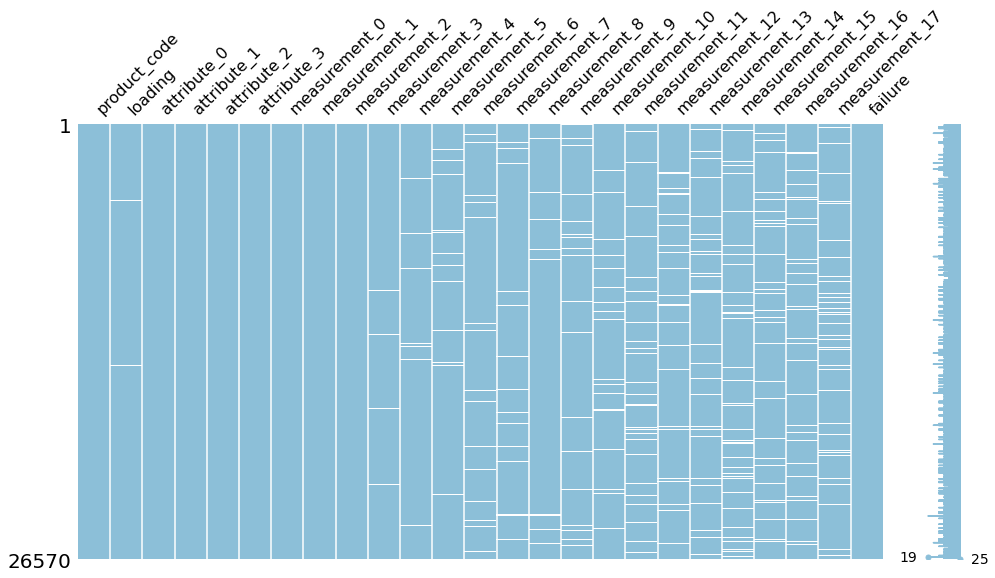

In [9]:
import missingno as msno
msno.matrix(train.drop('id', axis=1), color=(0.55, 0.75, 0.85), figsize=(16, 8))

#### Correlation plots
- Plotted the correlation heatmap to get a global idea of what features might be related to each other and may lead us to some feature engineering.
- We see two groups where feature-to-feature correlation might exist: 

> `measurement_17` seems to be correlated with `measurements_5 and 8`

> There seem to be also some sort of correlation between `attributes_2, 3` and `measurements_0, 1`

- There could be an opportunity for a new feature to be derived from these.


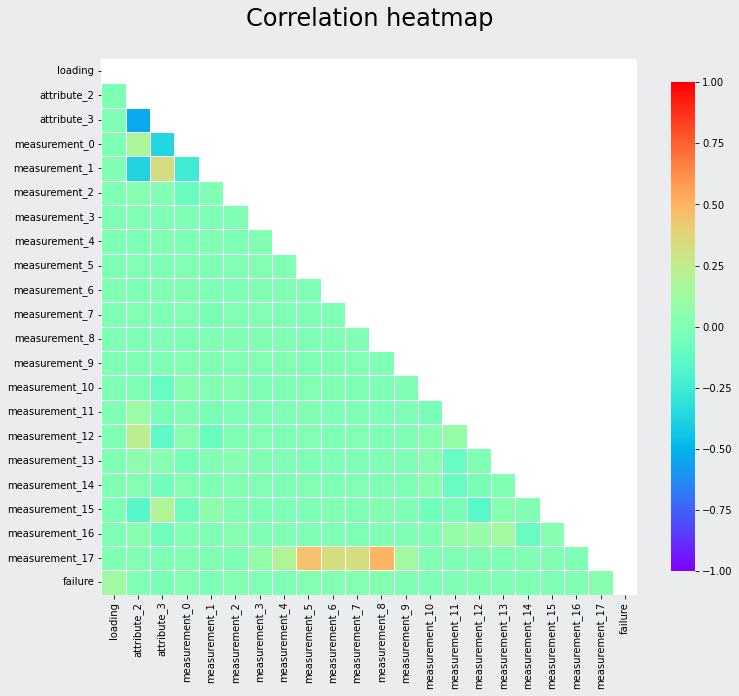

In [10]:
corr = train.drop('id', axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(12, 12), facecolor='#EAECEE')
cmap = sns.color_palette("rainbow", as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1., center=0, annot=False,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.75})

ax.set_title('Correlation heatmap', fontsize=24, y= 1.05)
colorbar = ax.collections[0].colorbar

In [11]:
target = train.pop('failure')
data = pd.concat([train, test])
train.shape,test.shape

((26570, 25), (20775, 25))

### 2. Pre-processing/FE
- Credits to the awosem notebook of Sawaimilert https://www.kaggle.com/code/takanashihumbert/tps-aug22-lb-0-59013

**Notes:**
- Tried different values of `n_neighbors` for the KNNImpute and found `n_neighbors=3` to be the best 
- I also tries other function such as `IterativeImputer` and `LGBMImputer` but `KNNImputer` was better than the rest.
- A new feature called `area` is created by multiplying `attribute_3` and `attrinute_3`.
- Measuerements 3 to 17 look very similar and are averaged to one new features, `measurement_avg`.
- Two other features are derived from [Ambros' notebook](https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense).  (`m3_missing` and `m5_missing`)

In [12]:
data['m3_missing'] = data['measurement_3'].isnull().astype(np.int8)
data['m5_missing'] = data['measurement_5'].isnull().astype(np.int8)
data['area'] = data['attribute_2'] * data['attribute_3']

feature = [f for f in test.columns if f.startswith('measurement') or f=='loading']

# dictionary of dictionaries (for the 11 best correlated measurement columns), 
# we will use the dictionaries below to select the best correlated columns according to the product code)
# Only for 'measurement_17' we make a 'manual' selection :

full_fill_dict ={}
full_fill_dict['measurement_17'] = {
    'A': ['measurement_5','measurement_6','measurement_8'],
    'B': ['measurement_4','measurement_5','measurement_7'],
    'C': ['measurement_5','measurement_7','measurement_8','measurement_9'],
    'D': ['measurement_5','measurement_6','measurement_7','measurement_8'],
    'E': ['measurement_4','measurement_5','measurement_6','measurement_8'],
    'F': ['measurement_4','measurement_5','measurement_6','measurement_7'],
    'G': ['measurement_4','measurement_6','measurement_8','measurement_9'],
    'H': ['measurement_4','measurement_5','measurement_7','measurement_8','measurement_9'],
    'I': ['measurement_3','measurement_7','measurement_8']
}


# collect the name of the next 10 best measurement columns sorted by correlation (except 17 already done above):
col = [col for col in test.columns if 'measurement' not in col]+ ['loading','m3_missing','m5_missing']
a = []
b =[]
for x in range(3,17):
    corr = np.absolute(data.drop(col, axis=1).corr()[f'measurement_{x}']).sort_values(ascending=False)
    a.append(np.round(np.sum(corr[1:4]),3)) # we add the 3 first lines of the correlation values to get the "most correlated"
    b.append(f'measurement_{x}')
c = pd.DataFrame()
c['Selected columns'] = b
c['correlation total'] = a
c = c.sort_values(by = 'correlation total',ascending=False).reset_index(drop = True)
print(f'Columns selected by correlation sum of the 3 first rows : ')
display(c.head(10))

for i in range(10):
    measurement_col = 'measurement_' + c.iloc[i,0][12:] # we select the next best correlated column 
    fill_dict ={}
    for x in data.product_code.unique() : 
        corr = np.absolute(data[data.product_code == x].drop(col, axis=1).corr()[measurement_col]).sort_values(ascending=False)
        measurement_col_dic = {}
        measurement_col_dic[measurement_col] = corr[1:5].index.tolist()
        fill_dict[x] = measurement_col_dic[measurement_col]
    full_fill_dict[measurement_col] =fill_dict
    
feature = [f for f in data.columns if f.startswith('measurement') or f=='loading']
nullValue_cols = [col for col in train.columns if train[col].isnull().sum()!=0]
    
for code in data.product_code.unique():
    total_na_filled_by_linear_model = 0
    print(f'\n-------- Product code {code} ----------\n')
    print(f'filled by linear model :')
    for measurement_col in list(full_fill_dict.keys()):
        tmp = data[data.product_code==code]
        column = full_fill_dict[measurement_col][code]
        tmp_train = tmp[column+[measurement_col]].dropna(how='any')
        tmp_test = tmp[(tmp[column].isnull().sum(axis=1)==0)&(tmp[measurement_col].isnull())]

        model = HuberRegressor(epsilon=1.9)
        model.fit(tmp_train[column], tmp_train[measurement_col])
        data.loc[(data.product_code==code)&(data[column].isnull().sum(axis=1)==0)&(data[measurement_col].isnull()),measurement_col] = model.predict(tmp_test[column])
        print(f'{measurement_col} : {len(tmp_test)}')
        total_na_filled_by_linear_model += len(tmp_test)
        
    # others NA columns:
    NA = data.loc[data["product_code"] == code,nullValue_cols ].isnull().sum().sum()
    model1 = KNNImputer(n_neighbors=3)
    #model1 = LGBMImputer(n_iter=50)
    #model1 = IterativeImputer(random_state=0) 
    data.loc[data.product_code==code, feature] = model1.fit_transform(data.loc[data.product_code==code, feature])
    print(f'\n{total_na_filled_by_linear_model} filled by linear model ') 
    print(f'{NA} filled by KNN ')
    
data['measurement_avg'] = data[[f'measurement_{i}' for i in range(3, 17)]].mean(axis=1)

Columns selected by correlation sum of the 3 first rows : 


,Selected columns,correlation total
0,measurement_8,0.448
1,measurement_11,0.395
2,measurement_5,0.376
3,measurement_6,0.359
4,measurement_7,0.330
5,measurement_4,0.328
6,measurement_15,0.301
7,measurement_10,0.300
8,measurement_16,0.252
9,measurement_14,0.225



-------- Product code A ----------

filled by linear model :
measurement_17 : 386
measurement_8 : 167
measurement_11 : 225
measurement_5 : 113
measurement_6 : 146
measurement_7 : 153
measurement_4 : 79
measurement_15 : 273
measurement_10 : 209
measurement_16 : 293
measurement_14 : 237

2281 filled by linear model 
1568 filled by KNN 

-------- Product code B ----------

filled by linear model :
measurement_17 : 418
measurement_8 : 165
measurement_11 : 220
measurement_5 : 83
measurement_6 : 106
measurement_7 : 174
measurement_4 : 80
measurement_15 : 294
measurement_10 : 197
measurement_16 : 358
measurement_14 : 330

2425 filled by linear model 
1550 filled by KNN 

-------- Product code C ----------

filled by linear model :
measurement_17 : 391
measurement_8 : 189
measurement_11 : 231
measurement_5 : 141
measurement_6 : 150
measurement_7 : 140
measurement_4 : 108
measurement_15 : 319
measurement_10 : 262
measurement_16 : 343
measurement_14 : 330

2604 filled by linear model 
1740 fill

In [13]:
print("Missing values in the combined dataset after pre-peocessing is: ", format(data.isna().sum().sum()))

Missing values in the combined dataset after pre-peocessing is:  0


#### Helper function for scaling

- Standard scaler:  source code https://www.kaggle.com/code/takanashihumbert/tps-aug22-lb-0-59013

In [14]:
def _scale(train_data, val_data, test_data, feats):
    scaler = StandardScaler()
       
    scaled_train = scaler.fit_transform(train_data[feats])
    scaled_val = scaler.transform(val_data[feats])
    scaled_test = scaler.transform(test_data[feats])
    
    #back to dataframe
    new_train = train_data.copy()
    new_val = val_data.copy()
    new_test = test_data.copy()
    
    new_train[feats] = scaled_train
    new_val[feats] = scaled_val
    new_test[feats] = scaled_test
    
    assert len(train_data) == len(new_train)
    assert len(val_data) == len(new_val)
    assert len(test_data) == len(new_test)
    
    return new_train, new_val, new_test

- Separate the train and test dataset

In [15]:
train = data.iloc[:train.shape[0],:]
test = data.iloc[train.shape[0]:,:]
print(train.shape, test.shape)

groups = train.product_code
X = train
y = target

(26570, 29) (20775, 29)


In [16]:
# library for coding string values #Thanks to @MAXSARMENTO:
! pip install feature_engine
from feature_engine.encoding import WoEEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 1.3 MB/s eta 0:00:00


In [17]:
woe_encoder = WoEEncoder(variables=['attribute_0'])
woe_encoder.fit(train, y)
X = woe_encoder.transform(train)
test = woe_encoder.transform(test)

#### Additional features
- These two new feaures came from [this discusion post.](https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/343368)

In [18]:
X['measurement(3*5)'] = X['measurement_3'] * X['measurement_5']
test['measurement(3*5)'] = test['measurement_3'] * test['measurement_5']

X['missing(3*5)'] = X['m5_missing'] * (X['m3_missing'])
test['missing(3*5)'] = test['m5_missing'] * (test['m3_missing'])

In [19]:
select_feature = [
    'loading',
    'attribute_0',
    'measurement_17',
    'measurement_0',
    'measurement_1',
    'measurement_2',
    'area',
    'm3_missing', 
    'm5_missing',
    'measurement_avg',
    'measurement(3*5)',
    'missing(3*5)',      
]

- Rounding the floating number columns to two decimal places. 

In [20]:
X = X.round(decimals=2)
test = test.round(decimals=2)

### 3. Model/LogisticRegression
- 5 fold CV model using a linear model (LR)
- We see that `loading` and `measurement_17` are the top two important features for our model. 
- Note also that the newly created features i.e, `m3_missing`, `m5_missing`, and `missing(3*5)` are among the top 10 important features.

Fold: 1
FOLD:  1  ROC-AUC: 0.59812
Fold: 2
FOLD:  2  ROC-AUC: 0.5924
Fold: 3
FOLD:  3  ROC-AUC: 0.58123
Fold: 4
FOLD:  4  ROC-AUC: 0.5928
Fold: 5
FOLD:  5  ROC-AUC: 0.58649
Average auc = 0.59021
OOF auc = 0.59007


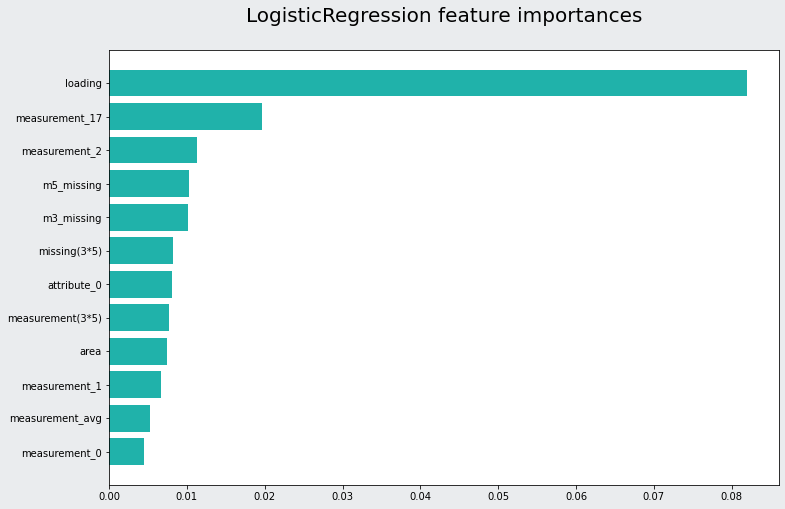

In [21]:
lr_oof = np.zeros(len(train))
lr_test = np.zeros(len(test))
lr_auc = 0
importance_list = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print("Fold:", fold_idx+1)
    x_train, x_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    x_train, x_val, x_test = _scale(x_train, x_val, test, select_feature)
    
    model = LogisticRegression(max_iter=200, C=0.0001, penalty='l2', solver='newton-cg')
    model.fit(x_train[select_feature], y_train)
    importance_list.append(model.coef_.ravel())

    val_preds = model.predict_proba(x_val[select_feature])[:, 1]
    print("FOLD: ", fold_idx+1, " ROC-AUC:", round(roc_auc_score(y_val, val_preds), 5))
    lr_auc += roc_auc_score(y_val, val_preds) / 5
    lr_test += model.predict_proba(x_test[select_feature])[:, 1] / 5
    lr_oof[val_idx] = val_preds

print(f"{Fore.GREEN}{Style.BRIGHT}Average auc = {round(lr_auc, 5)}{Style.RESET_ALL}")
print(f"{Fore.BLUE}{Style.BRIGHT}OOF auc = {round(roc_auc_score(y, lr_oof), 5)}{Style.RESET_ALL}")

importance_list.append(model.coef_.ravel())
importance_df = pd.DataFrame(np.array(importance_list).T, index=x_train[select_feature].columns)
importance_df['mean'] = importance_df.mean(axis=1).abs()
importance_df['feature'] = x_train[select_feature].columns
importance_df = importance_df.sort_values('mean', ascending=True).reset_index()

fig, ax = plt.subplots(figsize=(12, 8), facecolor='#EAECEE')
plt.barh(importance_df.index, importance_df['mean'], color='lightseagreen')

plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
plt.title('LogisticRegression feature importances', fontsize=20, y= 1.05)
plt.show()

### 4. Submission


In [22]:
sub = pd.DataFrame({'id': submission.id, 'failure': lr_test})
sub.to_csv("submission.csv", index=False)

In [23]:
sub.head()

,id,failure
0,26570,0.208919
1,26571,0.200283
2,26572,0.203517
3,26573,0.201749
4,26574,0.245839
